### 导包+加载数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 设置中文编码和负号的正常显示

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# jdata_action
# behavior

In [4]:
%%time
behavior = pd.read_csv('jdata_action.csv')

Wall time: 1min 17s


In [5]:
behavior = behavior[(behavior['action_time'] > '2018-03-30') & (behavior['action_time'] < '2018-04-15')]

In [6]:
behavior.head()

,user_id,sku_id,action_time,module_id,type
17,1455298,208441,2018-04-11 15:21:43,6190659,1
18,1455298,334318,2018-04-11 15:14:54,6190659,1
19,1455298,237755,2018-04-11 15:14:13,6190659,1
20,1455298,6422,2018-04-11 15:22:25,6190659,1
21,1455298,268566,2018-04-11 15:14:26,6190659,1


In [7]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7540394 entries, 17 to 37214234
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   sku_id       int64 
 2   action_time  object
 3   module_id    int64 
 4   type         int64 
dtypes: int64(4), object(1)
memory usage: 345.2+ MB


In [8]:
behavior.isnull().sum()

user_id        0
sku_id         0
action_time    0
module_id      0
type           0
dtype: int64

### 数据清洗

In [9]:
# 处理日期和时间
# action_time列进行处理，拆分出日期和时间列，并添加星期字段求出每天对应的星期，方便后续按时间纬度对数据进行分析

In [10]:
from datetime import datetime

In [11]:
# pd.to_datetime(behavior['action_time']).head()

In [12]:
behavior.head()

,user_id,sku_id,action_time,module_id,type
17,1455298,208441,2018-04-11 15:21:43,6190659,1
18,1455298,334318,2018-04-11 15:14:54,6190659,1
19,1455298,237755,2018-04-11 15:14:13,6190659,1
20,1455298,6422,2018-04-11 15:22:25,6190659,1
21,1455298,268566,2018-04-11 15:14:26,6190659,1


In [13]:
# 日期
behavior['date'] = pd.to_datetime(behavior['action_time']).dt.date

In [14]:
# 时间
behavior['hour'] = pd.to_datetime(behavior['action_time']).dt.hour

In [15]:
# 周
behavior['weekday'] = pd.to_datetime(behavior['action_time']).dt.day_name()

In [16]:
# 去除与分析无关的列
behavior.drop('module_id', axis=1, inplace=True)

In [17]:
# 将用户行为标签由数字改为由字符表示
behavior['type'].value_counts()

1    6229177
5     533890
2     480149
4     200399
3      96779
Name: type, dtype: int64

In [18]:
behavior_type = {1: 'pv', 2: 'pay', 3: 'fav', 4: 'comm', 5: 'cart'}
behavior['type'] = behavior['type'].apply(lambda x: behavior_type[x])

In [19]:
behavior.head()

,user_id,sku_id,action_time,type,date,hour,weekday
17,1455298,208441,2018-04-11 15:21:43,pv,2018-04-11,15,Wednesday
18,1455298,334318,2018-04-11 15:14:54,pv,2018-04-11,15,Wednesday
19,1455298,237755,2018-04-11 15:14:13,pv,2018-04-11,15,Wednesday
20,1455298,6422,2018-04-11 15:22:25,pv,2018-04-11,15,Wednesday
21,1455298,268566,2018-04-11 15:14:26,pv,2018-04-11,15,Wednesday


In [20]:
behavior['weekday'].value_counts()

Friday       1406980
Saturday     1388631
Tuesday       981200
Monday        966219
Thursday      949741
Sunday        924409
Wednesday     923214
Name: weekday, dtype: int64

In [21]:
# behavior['dayofweek'] = pd.to_datetime(behavior['action_time']).dt.dayofweek

In [22]:
# 查看weekday和dayofweek的对应关系

# pd.pivot_table(behavior, index='weekday', columns='dayofweek', values='user_id')

In [23]:
# 0  Monday
# 1  Tuesday
# 2  Wednesday
# 3  Thursday
# 4  Friday
# 5  Saturday
# 6  Sunday

In [24]:
# behavior.to_csv('behavior.csv')

In [25]:
# behavior.to_csv('behavior.xlsx')

### 分析模型构建分析指标

#### 流量指标分析

- **pv、uv、消费用户数占比、消费用户总访问量占比、消费用户人均访问量、跳失率**

In [26]:
# 总访问量

pv = behavior[behavior['type'] == 'pv']['user_id'].count()

In [27]:
# 总访客数

uv = behavior['user_id'].nunique()

In [28]:
# 消费用户数

user_pay = behavior[behavior['type'] == 'pay']['user_id'].unique()

In [29]:
# 消费用户数：
len(user_pay)

395874

In [30]:
# 日均访问量

# 日均访问量 = 总访问量 / 访问天数
pv_per_day = pv / behavior['date'].nunique()

In [31]:
# 人均访问量

# 人均访问量 = 总访问量 / 总人数
pv_per_user = pv / uv

In [32]:
# 消费用户访问量

pv_pay = behavior[behavior['user_id'].isin(user_pay)]['type'].value_counts()['pv']

In [33]:
# 消费用户数占比

user_pay_rate = len(user_pay) / uv

In [34]:
# 消费用户访问量占比

pv_pay_rate = pv_pay / pv

In [35]:
# 消费用户人均访问量

pv_per_buy_user = pv_pay / len(user_pay)

- 跳失率

In [36]:
# behavior.head(10000).to_csv('test.csv', encoding='UTF-8')

In [37]:
# 只进行一次操作就离开的用户数 / 总用户数
attrition_rates = sum(behavior.groupby('user_id')['type'].count() == 1) / uv

print('跳失率为：{}%'.format(round(attrition_rates * 100, 3)))

跳失率为：22.585%


#### 用户消费频次分析

In [38]:
# 单个用户消费总次数

total_by_count = behavior[behavior['type'] == 'pay'].groupby('user_id')['type'].count().reset_index().rename(columns={'type': 'total'}).sort_values(by='total', ascending=False)

In [39]:
# 消费次数前10客户

topbuyer10 = total_by_count.head(10)

In [40]:
# 复购率

re_buy_rate = total_by_count[total_by_count > 1]['total'].count() / total_by_count['total'].count()

In [41]:
# 或者：（结果同上）
# 复购率 = 购买次数>1的用户数 / 所有购买的用户数
sum(behavior[behavior['type'] == 'pay'].groupby('user_id')['type'].count() > 1) / behavior[behavior['type'] == 'pay']['user_id'].nunique()

0.13418916119775484

- 可视化

In [42]:
# 单个用户消费总次数可视化

#### 用户行为在时间纬度的分布

In [43]:
# 日活跃人数

# 有一次操作即视为活跃
daily_active_user = behavior.groupby('date')['user_id'].nunique()

In [44]:
# 日消费人数

daily_buy_user = behavior[behavior['type'] == 'pay'].groupby('date')['user_id'].nunique()

In [45]:
# 日消费人数占比

proportion_of_buyer = daily_buy_user / daily_active_user

In [46]:
# 日消费总次数

daily_buy_count = behavior[behavior['type'] == 'pay'].groupby('date')['type'].count()

In [47]:
# 消费用户日人均消费次数

consumption_per_buyer = daily_buy_count / daily_buy_user

- 可视化

In [48]:
# 柱状图数据：
pob_bar = pd.merge(daily_active_user, daily_buy_user, on='date').reset_index().rename(columns={'user_id_x': '日活跃人数', 'user_id_y': '日消费人数'}).set_index('date').stack().reset_index().rename(columns={'level_1': 'Variable', 0: 'Value'})

pob_bar.head(2)

,date,Variable,Value
0,2018-03-30,日活跃人数,105562
1,2018-03-30,日消费人数,25154


In [49]:
# 线图数据：
pob_line = proportion_of_buyer.reset_index().rename(columns={'user_id':'Rate'})

pob_line.head(2)

,date,Rate
0,2018-03-30,0.238287
1,2018-03-31,0.245711


Text(0.5, 1.0, '日消费人数占比')

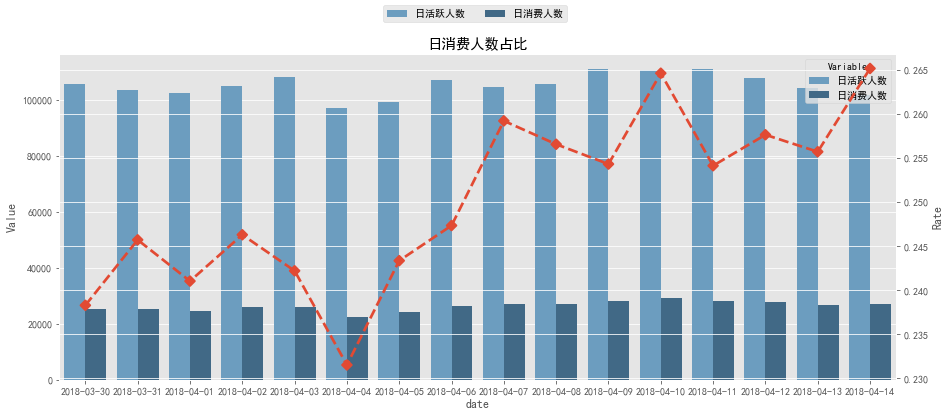

In [50]:
fig1 = plt.figure(figsize=(15, 6))
plt.style.use('ggplot')

ax1 = fig1.add_subplot(111)
ax2 = ax1.twinx()

sns.barplot(
    x = 'date',
    y = 'Value',
    hue = 'Variable',
    data = pob_bar,
    ax = ax1,
    palette = 'Blues_d',  # 调色盘色调
)

sns.pointplot(
    x = 'date',
    y = 'Rate',
    data = pob_line,
    ax = ax2,
    markers = 'D',
    linestyles = '--'
)

fig1.legend(loc='upper center', ncol=2)
plt.title('日消费人数占比')

- 日活跃人数与日消费人数**无明显波动**，日消费人数占比均在以上

Text(0.5, 1.0, '消费用户日人均消费次数')

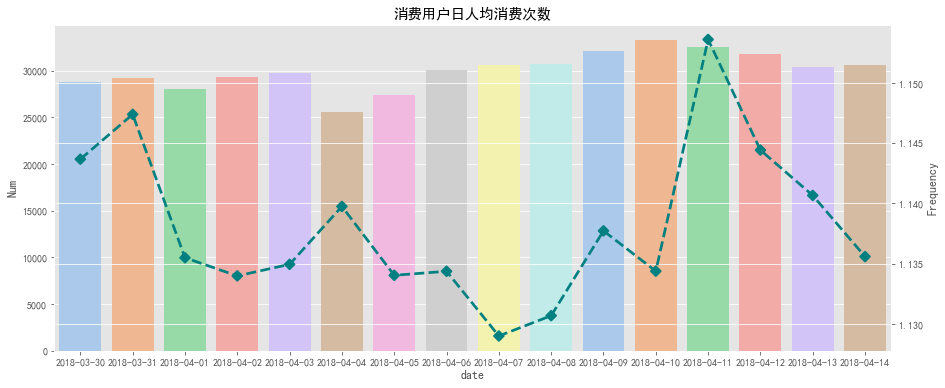

In [51]:
# 消费用户日人均消费次数可视化

# 线图数据：
fig2_line = consumption_per_buyer.reset_index().rename(columns={0: 'Frequency'})

# 柱状图数据：
fig2_bar = daily_buy_count.reset_index().rename(columns={'type': 'Num'})

# 画布大小
fig2 = plt.figure(figsize=(15, 6))
ax3 = fig2.add_subplot(111)
ax4 = ax3.twinx()

sns.barplot(
    x = 'date',
    y = 'Num',
    data = fig2_bar,
    ax = ax3,
    palette='pastel'
)

# 这种写法会报错，原因未知
# sns.pointplot(
#     x = 'date',
#     y = 'Frequency',
#     date = fig2_line,
#     ax = ax4,
#     markers='D', 
#     linestyles='--',
#     color='teal'
# )

sns.pointplot(
    x = fig2_line['date'],
    y = fig2_line['Frequency'],
    date = fig2_line,
    ax = ax4,
    markers='D', 
    linestyles='--',
    color='teal'
)

plt.title('消费用户日人均消费次数')

- 日消费人数在25000以上，日人均消费次数大于1次

In [52]:
df_dau3 = behavior.groupby(['date', 'user_id'])['type'].count().reset_index()

In [53]:
df_dau3 = df_dau3[df_dau3['type'] >= 3]

In [54]:
# 每日最高活跃用户数：
dau3_num = df_dau3.groupby('date')['user_id'].nunique()
dau3_num = dau3_num.reset_index()

<AxesSubplot:xlabel='date', ylabel='user_id'>

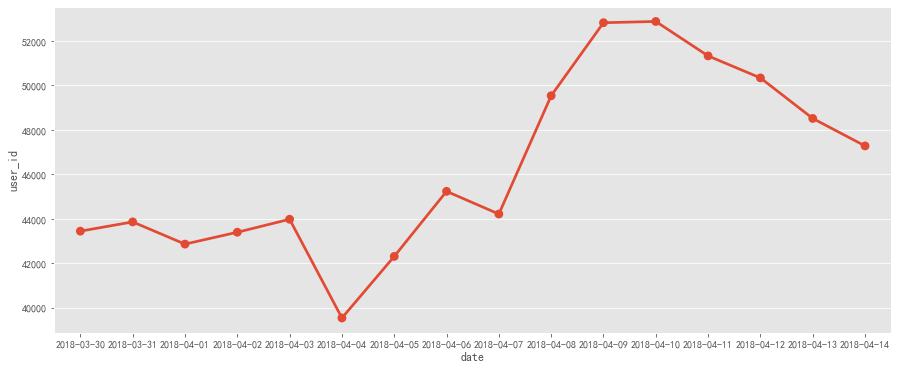

In [55]:
fig3 = plt.figure(figsize=(15, 6))

sns.pointplot(
    x = dau3_num['date'],
    y = dau3_num['user_id'],
    data = dau3_num
)

- 每日高活跃用户数在大部分4万以上，2018-04-04之前数量比较平稳，之后数量一直攀升，8号9号达到最高，随后下降，推测数据波动应为营销活动产生的。

In [56]:
# 高活跃用户累计活跃天数分布

# (每日高活跃用户数：操作数>=3)
dau3_cumsum = df_dau3.groupby('user_id')['date'].count().reset_index()

Text(0.5, 1.0, '高活跃用户累计活跃天数分布')

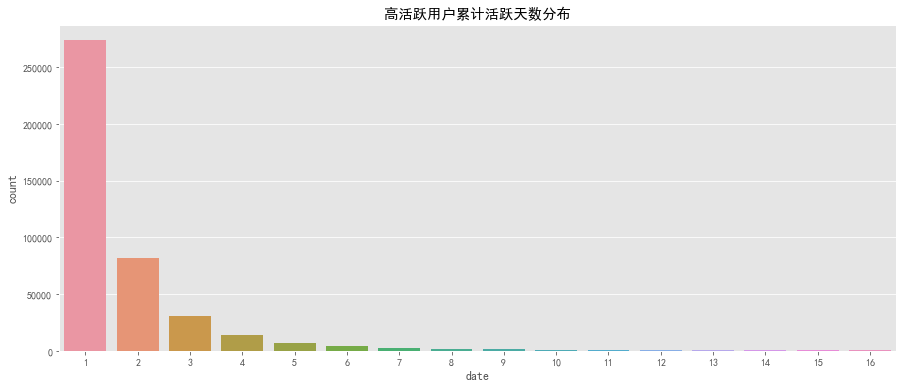

In [57]:
plt.figure(figsize=(15, 6))

sns.countplot(
    x = dau3_cumsum['date'],
    data = dau3_cumsum
)

plt.title('高活跃用户累计活跃天数分布')

# sns.countplot()函数
# 以bar的形式展示每个类别的数量

- 统计周期内，大部分高活跃用户累计活跃天数在六天以下，但也存在高达十六天的超级活跃用户数量，对累计天数较高的用户要推出连续登录奖励等继续维持其对平台的黏性，对累计天数较低的用户要适当进行推送活动消息等对其进行召回。

In [58]:
# 每日浏览量

pv_daily = behavior[behavior['type'] == 'pv'].groupby('date')['user_id'].count().reset_index()

In [59]:
# 每日访客数

uv_daily = behavior.groupby('date')['user_id'].nunique().reset_index()

Text(0.5, 1.0, '每日浏览量')

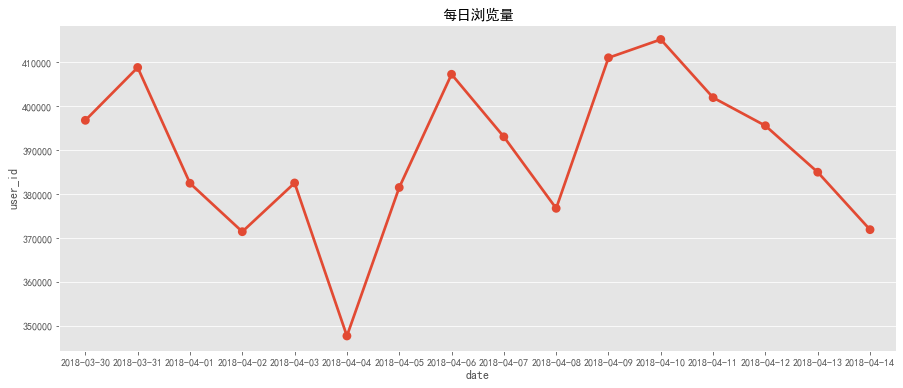

In [60]:
# 每日浏览量可视化

plt.figure(figsize=(15, 6))

sns.pointplot(
    x = 'date',
    y = 'user_id',
    data = pv_daily
)

plt.title('每日浏览量')

Text(0.5, 1.0, '每日访客数')

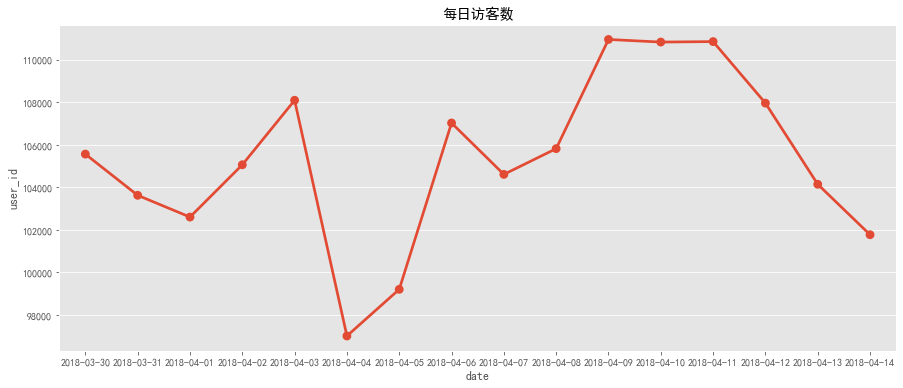

In [61]:
# 每日访客数可视化

plt.figure(figsize=(15, 6))

sns.pointplot(
    x = 'date',
    y = 'user_id',
    data = uv_daily
)

plt.title('每日访客数')

<AxesSubplot:xlabel='date', ylabel='user_id'>

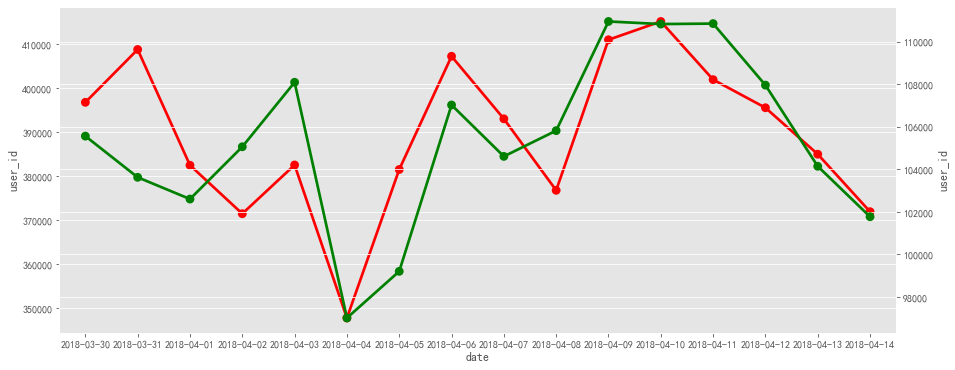

In [62]:
# 试着将每日的浏览量和访客数放到一张图

plt.figure(figsize=(15, 6))

ax5 = plt.subplot(111)
ax6 = ax5.twinx()

sns.pointplot(
    x = 'date',
    y = 'user_id',
    data = pv_daily,
    ax = ax5,
    color='red'
)

sns.pointplot(
    x = 'date',
    y = 'user_id',
    data = uv_daily,
    ax = ax6,
    color='green'
)

- 浏览量和访客数每日变化趋势大致相同，2018-04-04日前后用户数量变化波动较大，4月4日为清明节假日前一天，各数据量在当天均有明显下降，但之后逐步回升，推测应为节假日营销活动或推广拉新活动带来的影响。

In [63]:
# 每时浏览量

pv_hourly = behavior[behavior['type'] == 'pv'].groupby('hour')['user_id'].count().reset_index()

In [64]:
# 每时访客数

uv_hourly = behavior.groupby('hour')['user_id'].nunique().reset_index()

Text(0.5, 1.0, '浏览量、访客数随小时的变化')

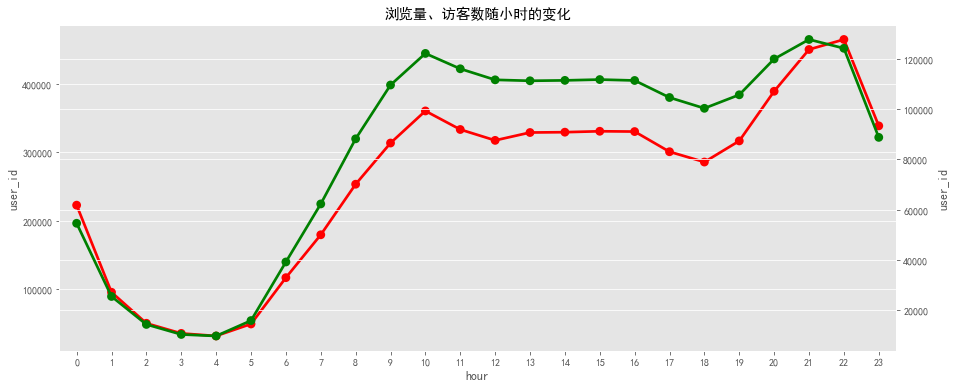

In [65]:
# 两张图放到一起

plt.figure(figsize=(15, 6))
ax7 = plt.subplot(111)
ax8 = ax7.twinx()


# 浏览量随小时变化可视化
sns.pointplot(
    x = 'hour',
    y = 'user_id',
    data = pv_hourly,
    ax = ax7,
    color='red'
)


# 访客数随小时变化可视化

sns.pointplot(
    x = 'hour',
    y = 'user_id',
    data = uv_hourly,
    ax = ax8,
    color='green'
)

plt.title('浏览量、访客数随小时的变化')

- 浏览量及访客数随小时变化趋势一致，在凌晨1点到凌晨5点之间，大部分用户正在休息，整体活跃度较低。凌晨5点到10点用户开始起床工作，活跃度逐渐增加，之后趋于平稳，下午6点之后大部分人恢复空闲，浏览量及访客数迎来了第二波攀升，在晚上8点中到达高峰，随后逐渐下降。可以考虑在上午9点及晚上8点增大商品推广力度，加大营销活动投入，可取的较好的收益，1点到5点之间适合做系统维护。

In [66]:
# 用户各操作随小时变化

type_detail_hour = pd.pivot_table(index='hour', columns='type', data=behavior, values='user_id', aggfunc=np.size)

In [67]:
# 用户各操作随星期变化

type_detail_weekday = pd.pivot_table(index='weekday', columns='type', data=behavior, values='user_id', aggfunc=np.size)

In [68]:
type_detail_weekday = type_detail_weekday.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [69]:
tdh_line = type_detail_hour.stack().reset_index().rename(columns={0: 'Value'})
tdw_line = type_detail_weekday.stack().reset_index().rename(columns={0: 'Value'})

tdh_line= tdh_line[~(tdh_line['type'] == 'pv')]
tdw_line= tdw_line[~(tdw_line['type'] == 'pv')]

Text(0.5, 1.0, '用户操作随小时变化')

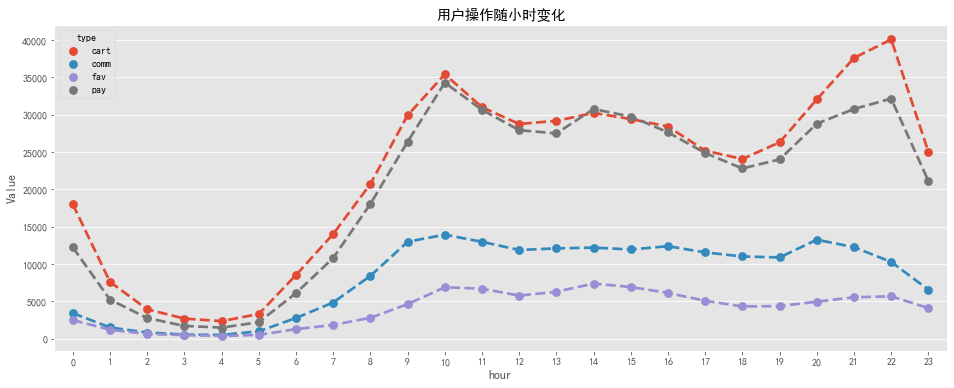

In [70]:
# 用户操作随小时变化可视化
fig, ax = plt.subplots(figsize=[16,6])
sns.pointplot(x='hour', y='Value', hue='type', data=tdh_line, linestyles='--')
plt.title('用户操作随小时变化')

- 用户操作随小时变化规律与PV、UV随小时规律相似，与用户作息规律相关，加入购物车和付款两条曲线贴合比比较紧密，说明大部分用户习惯加入购物车后直接购买。
- 关注数相对较少，可以根据用户购物车内商品进行精准推送。评论数也相对较少，说明大部分用户不是很热衷对购物体验进行反馈，可以设置一些奖励制度提高用户评论数，增大用用户粘性。

Text(0.5, 1.0, '用户操作随星期变化')

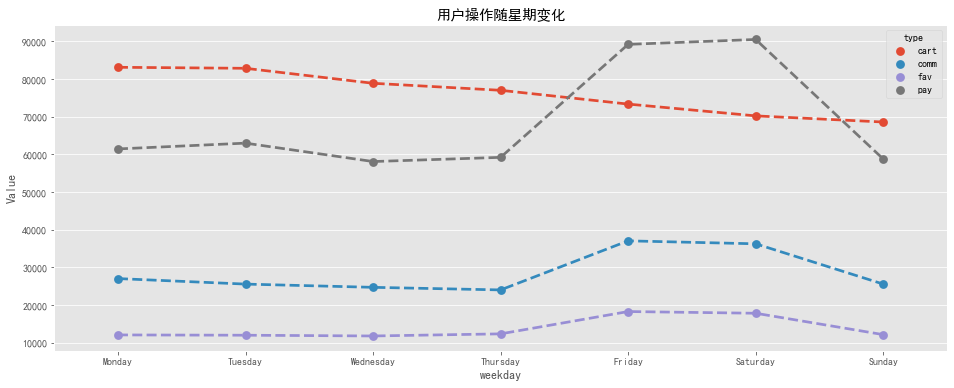

In [71]:
# 用户操作随星期变化可视化
fig, ax = plt.subplots(figsize=[16,6])
sns.pointplot(x='weekday', y='Value', hue='type', data=tdw_line[~(tdw_line['type'] == 'pv')], linestyles='--')
plt.title('用户操作随星期变化')

- 周一到周四工作日期间，用户操作随星期变化比较平稳，周五至周六进入休息日，用户操作明显增多，周日又恢复正常。

#### 用户行为转化漏斗

In [72]:
from pyecharts import options as opts
from pyecharts.charts import Funnel
import math

In [73]:
behavior['action_time']

17          2018-04-11 15:21:43
18          2018-04-11 15:14:54
19          2018-04-11 15:14:13
20          2018-04-11 15:22:25
21          2018-04-11 15:14:26
                   ...         
37214218    2018-04-02 11:03:15
37214219    2018-04-02 10:47:52
37214220    2018-04-02 10:27:44
37214226    2018-04-12 08:03:11
37214234    2018-04-12 14:02:17
Name: action_time, Length: 7540394, dtype: object

In [74]:
# action_time 转换数据类型
behavior['action_time'] = pd.to_datetime(behavior['action_time'], format='%Y-%m-%d %H:%M:%S')

In [75]:
# 用户整体行为分布

type_dis = behavior['type'].value_counts().reset_index()
type_dis['rate'] = round(type_dis['type'] / type_dis['type'].sum(), 3)
type_dis

,index,type,rate
0,pv,6229177,0.826
1,cart,533890,0.071
2,pay,480149,0.064
3,comm,200399,0.027
4,fav,96779,0.013


In [76]:
type_dis.style.bar(color='skyblue', subset='rate')

,index,type,rate
0,pv,6229177,0.826000
1,cart,533890,0.071000
2,pay,480149,0.064000
3,comm,200399,0.027000
4,fav,96779,0.013000


- 用户整体行为中，有82.6%行为为浏览，实际支付操作仅占6.4,除此之外，用户评论及收藏的行为占比也较低，应当增强网站有用户之间的互动，提高评论数量和收藏率。

In [77]:
df_con = behavior[['user_id', 'sku_id', 'action_time', 'type']]

In [78]:
df_pv = df_con[df_con['type'] == 'pv']
df_fav = df_con[df_con['type'] == 'fav']
df_cart = df_con[df_con['type'] == 'cart']
df_pay = df_con[df_con['type'] == 'pay']

In [79]:
df_pv_uid = df_pv['user_id'].unique()
df_fav_uid = df_fav['user_id'].unique()
df_cart_uid = df_cart['user_id'].unique()
df_pay_uid = df_pay['user_id'].unique()

##### pv - buy

In [80]:
fav_cart_list = set(df_cart_uid) | set(df_fav_uid)

In [81]:
df_pv_pay = pd.merge(left=df_pv, right=df_pay, how='inner', on=['user_id', 'sku_id'], suffixes=['_pv', '_pay']) 

In [82]:
# 过滤挑个条件：
# 1. 没有fav（收藏）和cart（加购）的用户
# 2. pay操作一定要在pv操作前

df_pv_pay = df_pv_pay[(~df_pv_pay['user_id'].isin(fav_cart_list)) & (df_pv_pay['action_time_pay'] > df_pv_pay['action_time_pv'])]

In [83]:
uv = behavior['user_id'].nunique()
pv_pay_num = df_pv_pay['user_id'].nunique()

In [84]:
pv_pay_data = pd.DataFrame({'type': ['浏览', '付款'], 'num': [uv, pv_pay_num]})
pv_pay_data['conversion_rate'] = round(pv_pay_data['num'] / pv_pay_data['num'][0], 4) * 100

In [85]:
pv_pay_data

,type,num,conversion_rate
0,浏览,728959,100.00
1,付款,156456,21.46


In [86]:
attr1 = list(pv_pay_data['type'])
values1 = list(pv_pay_data['conversion_rate'])
data1 = [[attr1[i], values1[i]] for i in range(len(attr1))]

In [87]:
data1

[['浏览', 100.0], ['付款', 21.46]]

In [88]:
# 用户行为转化漏斗可视化

pv_pay = (
    Funnel(init_opts=opts.InitOpts(width='600px', height='300px'))
    .add(
        series_name='',
        data_pair=data1,
        gap=2
    )
    .set_global_opts(title_opts=opts.TitleOpts(title='用户行为转化漏斗图',subtitle='这是啥标题， 好像是副标题'))
)

pv_pay.render_notebook()

##### pv - cart - pay

In [89]:
df_pv_cart = pd.merge(left=df_pv, right=df_cart, how='inner', on=['user_id', 'sku_id'], suffixes=['_pv', '_cart'])

In [90]:
df_pv_cart = df_pv_cart[(~df_pv_cart['user_id'].isin(df_fav['user_id'])) & (df_pv_cart['action_time_cart'] > df_pv_cart['action_time_pv'])]

In [91]:
df_pv_cart_pay = pd.merge(left=df_pv_cart, right=df_pay, how='inner', on=['user_id', 'sku_id'])
df_pv_cart_pay = df_pv_cart_pay.rename(columns={'action_time': 'action_time_pay'})

In [92]:
df_pv_cart_pay = df_pv_cart_pay[(~df_pv_cart_pay['user_id'].isin(df_fav['user_id'])) & (df_pv_cart_pay['action_time_pay'] > df_pv_cart_pay['action_time_cart'])]

In [93]:
uv = behavior['user_id'].nunique()
pv_cart_num = df_pv_cart['user_id'].nunique()
pv_cart_pay_num = df_pv_cart_pay['user_id'].nunique()

In [94]:
pv_cart_pay_data = pd.DataFrame({'type': ['浏览', '加购', '购买'], 'num': [uv, pv_cart_num, pv_cart_pay_num]})
pv_cart_pay_data['conversion_rate'] = round(pv_cart_pay_data['num'] / pv_cart_pay_data['num'][0], 4) * 100

In [95]:
pv_cart_pay_data

,type,num,conversion_rate
0,浏览,728959,100.00
1,加购,155554,21.34
2,购买,90893,12.47


In [96]:
# 测试，忽略
pv_cart_pay_data['type'][0]

'浏览'

In [97]:
data2 = [[pv_cart_pay_data['type'][i], pv_cart_pay_data['conversion_rate'][i]] for i in range(len(pv_cart_pay_data['type']))]

In [98]:
data2

[['浏览', 100.0], ['加购', 21.34], ['购买', 12.47]]

In [99]:
pv_cart_pay = (
    Funnel(init_opts=opts.InitOpts(width='600px', height='300px'))
    .add(
        series_name='',
        data_pair=data2,
        gap=2
    )
    .set_global_opts(title_opts=opts.TitleOpts(title='用户行为转化漏斗图'))
)

pv_cart_pay.render_notebook()

##### pv - fav - pay

In [100]:
df_pv_fav = pd.merge(left=df_pv, right=df_fav, how='inner', on=['user_id', 'sku_id'], suffixes=['_pv', '_fav'])

In [101]:
df_pv_fav = df_pv_fav[(~df_pv_fav['user_id'].isin(df_cart['user_id'])) & (df_pv_fav['action_time_fav'] > df_pv_fav['action_time_pv'])]

In [102]:
df_pv_fav_pay = pd.merge(left=df_pv_fav, right=df_pay, how='inner', on=['user_id', 'sku_id'])
df_pv_fav_pay = df_pv_fav_pay.rename(columns={'action_time': 'action_time_pay'})

In [103]:
df_pv_fav_pay = df_pv_fav_pay[(~df_pv_fav_pay['user_id'].isin(df_cart['user_id'])) & (df_pv_fav_pay['action_time_pay'] > df_pv_fav_pay['action_time_fav'])]

In [104]:
uv = behavior['user_id'].nunique()
pv_fav_num = df_pv_cart['user_id'].nunique()
pv_fav_pay_num = df_pv_fav_pay['action_time_pay'].nunique()

In [105]:
pv_fav_pay_data = pd.DataFrame({'type': ['浏览', '收藏', '付款'], 'num': [uv, pv_fav_num, pv_fav_pay_num]})
pv_fav_pay_data['conversion_rate'] = round(pv_fav_pay_data['num'] / pv_fav_pay_data['num'][0], 4) * 100

In [106]:
pv_fav_pay_data

,type,num,conversion_rate
0,浏览,728959,100.00
1,收藏,155554,21.34
2,付款,12513,1.72


In [107]:
data3 = [[pv_fav_pay_data['type'][i], [pv_fav_pay_data['conversion_rate'][i]]] for i in range(len(pv_fav_pay_data['type']))]

In [108]:
data3

[['浏览', [100.0]], ['收藏', [21.34]], ['付款', [1.72]]]

In [109]:
pv_fav_pay = (
    Funnel(init_opts=opts.InitOpts(width='600px', height='300px'))
    .add(
        series_name='',
        data_pair=data3,
        gap=2
    )
    .set_global_opts(title_opts=opts.TitleOpts(title='标题'))
)

pv_fav_pay.render_notebook()

##### pv - fav - cart - pay

In [110]:
# pv - fav

df_pv_fav = pd.merge(left=df_pv, right=df_fav, how='inner', on=['user_id', 'sku_id'], suffixes=['_pv', '_fav'])
df_pv_fav = df_pv_fav[df_pv_fav['action_time_fav'] > df_pv_fav['action_time_pv']]

In [111]:
# pv - fav - cart

df_pv_fav_cart = pd.merge(left=df_pv_fav, right=df_cart, how='inner', on=['user_id', 'sku_id'])
df_pv_fav_cart = df_pv_fav_cart.rename(columns={'action_time': 'action_time_cart', 'type': 'type_cart'})

In [112]:
# pv - fav - cart - pay

df_pv_fav_cart_pay = pd.merge(left=df_pv_fav_cart, right=df_pay, how='inner', on=['user_id', 'sku_id'])
df_pv_fav_cart_pay = df_pv_fav_cart_pay.rename(columns={'action_time': 'action_time_pay', 'type': 'type_pay'})

In [113]:
uv = behavior['user_id'].nunique()
pv_fav_num = df_pv_fav['user_id'].nunique()
pv_fav_cart_num = df_pv_fav_cart['user_id'].nunique()
pv_fav_cart_pay_num = df_pv_fav_cart_pay['user_id'].nunique()

In [114]:
pv_fav_cart_pay_data = pd.DataFrame({'type': ['浏览', '收藏', '加购', '付款'], 'num': [uv, pv_fav_num, pv_fav_cart_num, pv_fav_cart_pay_num]})
pv_fav_cart_pay_data['conversion_rate'] = round(pv_fav_cart_pay_data['num'] / pv_fav_cart_pay_data['num'][0], 4) * 100

In [115]:
pv_fav_cart_pay_data

,type,num,conversion_rate
0,浏览,728959,100.00
1,收藏,45873,6.29
2,加购,14954,2.05
3,付款,10803,1.48


In [116]:
data4 = [[pv_fav_cart_pay_data['type'][i], pv_fav_cart_pay_data['conversion_rate'][i]] for i in range(len(pv_fav_cart_pay_data['type']))]

In [117]:
data4

[['浏览', 100.0], ['收藏', 6.29], ['加购', 2.0500000000000003], ['付款', 1.48]]

In [118]:
pv_fav_cart_pay = (
    Funnel(init_opts=opts.InitOpts(width='600px', height='300px'))
    .add(
        series_name='',
        data_pair=data4,
        gap=2
    )
    .set_global_opts(title_opts=opts.TitleOpts(title='标题'))
)

pv_fav_cart_pay.render_notebook()

- 比较四种不同的转化方式，最有效的转化路径为浏览直接付款转化率为21.46%，其次为浏览加购付款，转化率为12.47%，可以发现随着结算方式越来越复杂转化率越来越低。
- 加购的方式比收藏购买的方式转化率要高，推其原因为购物车接口进入方便且可以做不同商家比价用，而收藏则需要更繁琐的操作才可以查看到商品，因此转化率较低。
- 可以优化商品搜索功能，提高商品搜索准确度、易用性，减少用户搜索时间。
- 根据用户喜好在首页进行商品推荐，优化重排商品详情展示页，提高顾客下单欲望，提供一键购物等简化购物步骤的功能。
- 客服也可以留意加购及关注用户，适时推出优惠福利及时解答用户问题，引导用户购买以进一步提高转化率。
- 对于用户消费时间间隔，可以通过限时领券购买、限时特惠价格等进一步缩短用户付款时间，提高订单量。

In [119]:
behavior['action_time'].min()

Timestamp('2018-03-30 00:00:00')

In [120]:
behavior['action_time'].max()

Timestamp('2018-04-14 23:59:59')

#### 用户留存率分析

In [121]:
first_day = datetime.date(datetime.strptime('2018-03-30', '%Y-%m-%d'))
fifth_day = datetime.date(datetime.strptime('2018-04-03', '%Y-%m-%d'))
tenth_day = datetime.date(datetime.strptime('2018-04-08', '%Y-%m-%d'))
fifteenth_day = datetime.date(datetime.strptime('2018-04-13', '%Y-%m-%d'))

In [122]:
# 第一天新增用户数
df_firstday_user = behavior[behavior['date'] == first_day]['user_id'].to_frame()

# 第五天留存用户数
df_fifthday_user = behavior[behavior['date'] == fifth_day]['user_id'].to_frame()

# 第十天留存用户数
df_tenthday_user = behavior[behavior['date'] == tenth_day]['user_id'].to_frame()

# 第十五天留存用户数
df_fifteenthday_user = behavior[behavior['date'] == fifteenth_day]['user_id'].to_frame()

In [123]:
# 五天留存率
fifth_day_retention_rate = round(pd.merge(left=df_firstday_user, right=df_fifthday_user, how='inner', on='user_id')['user_id'].nunique() / df_firstday_user['user_id'].nunique(), 4)

In [124]:
# 十天留存率
tenth_day_retention_rate = round(pd.merge(left=df_firstday_user, right=df_tenthday_user, how='inner', on='user_id')['user_id'].nunique() / df_firstday_user['user_id'].nunique(), 4)

In [125]:
# 十五天留存率
fifteenth_day_retention_rate = round(pd.merge(left=df_firstday_user, right=df_fifteenthday_user, how='inner', on='user_id')['user_id'].nunique() / df_firstday_user['user_id'].nunique(), 4)

In [126]:
df_retention_rate = pd.DataFrame({'n日留存率': ['五日留存率', '十日留存率', '十五日留存率'], 'Rate': [fifth_day_retention_rate, tenth_day_retention_rate, fifteenth_day_retention_rate]})

In [127]:
# 可视化

<AxesSubplot:xlabel='n日留存率', ylabel='Rate'>

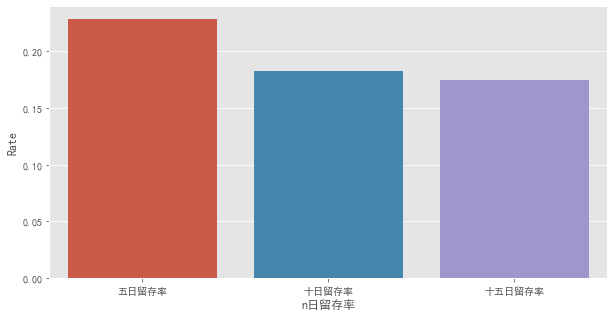

In [128]:
# seaborn
plt.figure(figsize=(10, 5))

sns.barplot(
    x = 'n日留存率',
    y = 'Rate',
    data=df_retention_rate
)

In [129]:
# pyecharts
from pyecharts.charts import Bar

a = (
    Bar(init_opts=opts.InitOpts(width='700px', height='450px'))
    .add_xaxis(list(df_retention_rate['n日留存率']))
    .add_yaxis('', list(df_retention_rate['Rate']))
    .set_global_opts(title_opts=opts.TitleOpts(title='留存率', subtitle='我是副标题'))
)
a.render_notebook()

- 留存率反应了产品质量和保留用户的能力，按照Facebook平台流传出留存率“40–20–10”规则（规则中的数字表示的是次日留存率、第7日留存率和第30日留存率），统计周期内第五日留存率为22.81%，第15日留存率为17.44%。
- 反映出平台的用户依赖性较高，也因平台发展已经到达稳定阶段，用户保留率不会发生较大波动，数据量足够的情况下可以以年为单位，计算按月的留存率。要合理安排消息推送，推出签到有奖等机制提高用户粘性，进一步提高留存率。

#### 商品销量分析

In [130]:
# 商品总数
behavior['sku_id'].nunique()

239007

In [131]:
# 商品被购买前产生平均操作次数

df_sku = behavior[behavior['sku_id'].isin(behavior[behavior['type'] == 'pay']['sku_id'].unique())].groupby('sku_id')['type'].value_counts().unstack(fill_value=0)

In [132]:
df_sku['total'] = df_sku.sum(axis=1)

In [133]:
df_sku.head()

type,cart,comm,fav,pay,pv,total
sku_id,,,,,,
13,0,0,0,1,8,9
17,1,1,0,1,12,15
22,0,0,0,1,3,4
24,5,0,1,5,50,61
26,0,1,0,1,28,30


In [134]:
df_sku['avg_beha'] = round(df_sku['total'] / df_sku['pay'], 2)

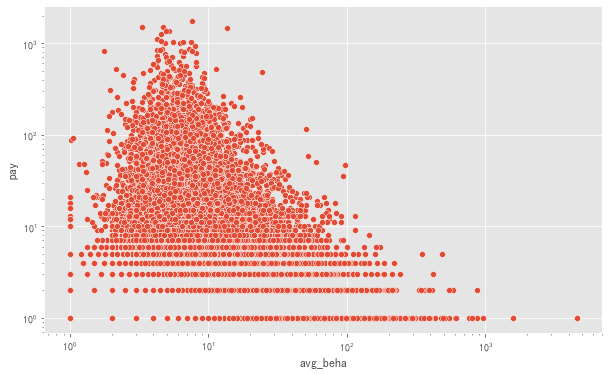

In [135]:
# seaborn

fig= plt.figure(figsize=(10, 6))
ax = plt.subplot()

sns.scatterplot(
    x = 'avg_beha',
    y = 'pay',
    data=df_sku
)
ax.set_xscale('log')
ax.set_yscale('log')

- 左下角操作少购买少，属于冷门购买频率较低的产品。
- 左上角操作少购买多，属于快消类产品，可选择品牌少，少数品牌垄断的行业。
- 右下角操作多购买少，品牌多，但是购买频率低，应为贵重物品类。
- 右上角操作多购买多，大众品牌，可选多，被购买频次高。

In [136]:
# 商品销量排行
df_pay_sku = behavior[behavior['type'] == 'pay'].groupby('sku_id')['type'].count().to_frame().rename(columns={'type': 'total'}).reset_index()

In [137]:
# 销量大于1000的商品
top_pay_sku = df_pay_sku[df_pay_sku['total'] > 1000].sort_values('total', ascending=False)

In [138]:
# 单个用户共购买商品总数
sku_num_per_user = behavior[behavior['type'] == 'pay'].groupby('user_id')['sku_id'].nunique()

In [139]:
top_pay_sku.set_index('sku_id').style.bar(color='skyblue', subset='total')

,total
sku_id,
152092,1736
37284,1517
232801,1503
224207,1448
44024,1350
327151,1343
125519,1269
83032,1100
261934,1058


#### RFM用户分层
- R Recency 最近一次消费时间 （消费时间越近的客户价值越大）
- F Frequency 消费频率 （用户在统计周期内购买商品的次数）
- M Monetary 消费金额 （指用户在统计周期内消费的总金额）

In [ ]:
# 此数据集缺少金额（M）

In [150]:
pay_group = behavior[behavior['type'] == 'pay'].groupby('user_id')['date']

In [157]:
# 将 behavior['date'].max() 作为“今天”
final_day = behavior['date'].max()

In [171]:
recent_pay_time = pay_group.apply(lambda x: final_day - x.max()).to_frame()

In [172]:
# 也可以这么写
# recent_pay_time = pd.DataFrame(final_day - pay_group.max())

In [180]:
recent_pay_time = recent_pay_time.reset_index().rename(columns={'date': 'recent'})

In [196]:
buy_freq = pay_group.count().reset_index().rename(columns={'date': 'freq'})

In [197]:
RFM = pd.merge(left=recent_pay_time, right=buy_freq, how='inner', on='user_id')

In [203]:
# 天数小标签为1天数大标签为0
RFM['R'] = pd.qcut(RFM.recent, 2, labels=['1', '0'])

In [207]:
# 频率大标签为1频率小标签为0
RFM['F'] = pd.qcut(RFM.freq.rank(method='first'), 2, labels=['0', '1'])

In [216]:
RFM['RFM'] = RFM['R'].astype(int).map(str) + RFM['F'].astype(int).map(str)

In [218]:
dict_n={'01':'重要保持客户',
        '11':'重要价值客户',
        '10':'重要挽留客户',
        '00':'一般发展客户'}

In [220]:
RFM['用户等级'] = RFM['RFM'].map(dict_n)

In [224]:
RFM_pie = RFM['用户等级'].value_counts().reset_index()

In [229]:
RFM_pie['Rate'] = RFM_pie['用户等级'] / RFM_pie['用户等级'].sum()

In [231]:
RFM_pie

,index,用户等级,Rate
0,重要价值客户,109290,0.276073
1,重要挽留客户,103691,0.261929
2,一般发展客户,94246,0.238071
3,重要保持客户,88647,0.223927


In [272]:
# 可视化

from pyecharts.charts import Pie

c = (
    Pie(init_opts=opts.InitOpts(width='700px', height='400px'))
    .add('', [list(z) for z in zip(RFM_pie['index'], RFM_pie['Rate'])])
    .set_global_opts(title_opts=opts.TitleOpts(title='RFM可视化'))
    .set_series_opts(label_opts=opts.LabelOpts(formatter='{b}: {c}'))
)

c.render_notebook()